In [1]:
import HT_generate_trajectory as trajgen_thinh
import get_solver_cmpc as cmpc
import numpy as np
import yaml
## Load parameters from config file
with open('Config_Crazyflie.yaml') as f:
    system_parameters = yaml.load(f,Loader=yaml.FullLoader)

qtm_ip = system_parameters['qtm_ip']
Ts = system_parameters['Ts']
Tsim = system_parameters['Tsim']
m = system_parameters['mass']
uris = system_parameters['uris']
drone_bodies = system_parameters['drone_bodies']

## Load Trajectories for drones:
ref = {}
full_ref1 = trajgen_thinh.get_ref_setpoints_Khanh(psi=0,Tsim=Tsim,dt=Ts,agent=1)
full_ref2 = trajgen_thinh.get_ref_setpoints_Khanh(psi=0,Tsim=Tsim,dt=Ts,agent=2)
full_ref3 = trajgen_thinh.get_ref_setpoints_Khanh(psi=0,Tsim=Tsim,dt=Ts,agent=3)
ref = {uris[0]: full_ref1["trajectory"],
       uris[1]: full_ref2["trajectory"],
      uris[2]: full_ref3["trajectory"]} 

vref = {uris[0]: full_ref1["v_ref"],
        uris[1]: full_ref2["v_ref"],
        uris[2]: full_ref3["v_ref"]}

common_plant,common_controller = cmpc.load_constant_parameters(Ts=Ts)
drone_params = {}
for i in range(len(drone_bodies)):
    drone_params[i] = cmpc.droneParameters(drone_address=uris[i],body_name=drone_bodies[i],mass=m[i],
                                                         plant=common_plant,controller=common_controller) 


In [2]:
central_plant,central_controller,simulator = cmpc.get_stacked_drones_parameters(list_of_drones=drone_params)
simulator['Nsim'] = np.size(ref[uris[0]],0)
CMPC_solver,CMPC_solver_variables = cmpc.get_solver_cmpc(plant=central_plant,controller=central_controller,simulator=simulator)



In [6]:
import numpy as np
simulator['u_sim'] = np.zeros((common_plant['du'],simulator['Nsim'],simulator['na']))
simulator['x_sim'] = np.zeros((common_plant['dx'],simulator['Nsim']+1,simulator['na']))
simulator['U_total'] = np.zeros((central_plant['du'],simulator['Nsim']))
simulator['X_total'] = np.zeros((central_plant['dx'],simulator['Nsim']+1))
for i in range(simulator['na']):
    simulator['u_sim'][:,:,i] = np.zeros((common_plant['du'],simulator['Nsim']))
    simulator['x_sim'][:,0,i] = ref[uris[i]][0,:].T 

ref[uris[1]][0,:].T 

array([-5.00000000e-01,  0.00000000e+00,  3.00000000e-01,  0.00000000e+00,
        0.00000000e+00, -1.44328993e-17])

In [4]:
print(np.size(simulator['U_total'],1))
import HT_control_packagecf as ctrl
import CFmodel

150


In [5]:
# k = 0
# import time 
# start = time.perf_counter()
# while(k< simulator['Nsim']-1):
#     if k==0:
#         u_init = np.zeros((central_plant['du'],1))
#     else:
#         u_init = simulator['U_total'][:,k]
    
#     simulator['X_ref'] = cmpc.get_ref_pred_horz(ref=ref,k=k,Npred=common_controller['Npred']+1,uris=uris)
#     simulator['v_ref'] = cmpc.get_ref_pred_horz(ref=vref,k=k,Npred=common_controller['Npred'],uris=uris)
    
#     simulator['U_total'][:,k] = cmpc.compute_control_cmpc(solver=CMPC_solver,solver_variables=CMPC_solver_variables,X0=simulator['X_total'][:,k],
#                               v0=u_init,Xrefk=simulator['X_ref'],vrefk = simulator['v_ref'],yawk = 0)
#     controls = {}
#     for i in range(simulator['na']):
#         simulator['u_sim'][:,k,i] = simulator['U_total'][i*(common_plant['du']):(i+1)*(common_plant['du']),k]

        
#         simulator['x_sim'][:,k+1,i] = common_plant['Ad'] @ simulator['x_sim'][:,k,i] + common_plant['Bd'] @ simulator['u_sim'][:,k,i]

#     k = k+1 
# end = time.perf_counter()
# calcul_t = end-start

In [5]:
k = 0
import time 
start = time.perf_counter()
while(k< simulator['Nsim']):
    if k==0:
        u_init = np.zeros((central_plant['du'],1))
    else:
        u_init = simulator['U_total'][:,k-1]
    
    simulator['X_ref'] = cmpc.get_ref_pred_horz(ref=ref,k=k,Npred=common_controller['Npred']+1,uris=uris)
    simulator['v_ref'] = cmpc.get_ref_pred_horz(ref=vref,k=k,Npred=common_controller['Npred'],uris=uris)
    for i in range(simulator['na']):
        simulator['X_total'][i*(common_plant['dx']):(i+1)*(common_plant['dx']),k] = simulator['x_sim'][:,k,i]
    
    simulator['U_total'][:,k] = cmpc.compute_control_cmpc(solver=CMPC_solver,solver_variables=CMPC_solver_variables,X0=simulator['X_total'][:,k],
                              v0=u_init,Xrefk=simulator['X_ref'],vrefk = simulator['v_ref'],yawk = 0)
    controls = {}
    for i in range(simulator['na']):
        simulator['u_sim'][:,k,i] = simulator['U_total'][i*(common_plant['du']):(i+1)*(common_plant['du']),k]

        # compute real control u
        controls[uris[i]] = ctrl.get_real_input(v_controls=simulator['u_sim'][:,k,i],yaw=0)
        
        # disturbance
        disturb = np.zeros((1,3))
        disturb = disturb + np.random.normal(loc=0.0,scale=0.03,size=(1,3))
        simulator['x_sim'][:,k+1,i] = CFmodel.CFmodel(xk=simulator['x_sim'][:,k,i],urk= controls[uris[i]],plant=common_plant,disturb=disturb)

    k = k+1 
end = time.perf_counter()
calcul_t = end-start

In [ ]:
cmpc.get_ref_pred_horz(ref=ref,k=150,Npred=common_controller['Npred']+1,uris=uris)


In [6]:

calcul_t/simulator['Nsim']


0.10402662743998614

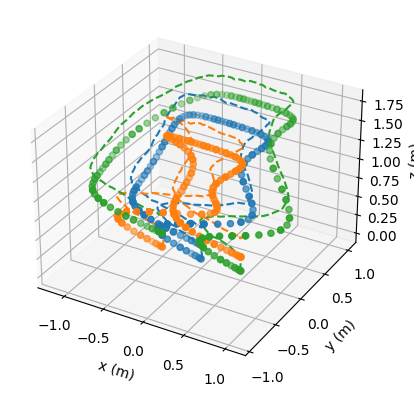

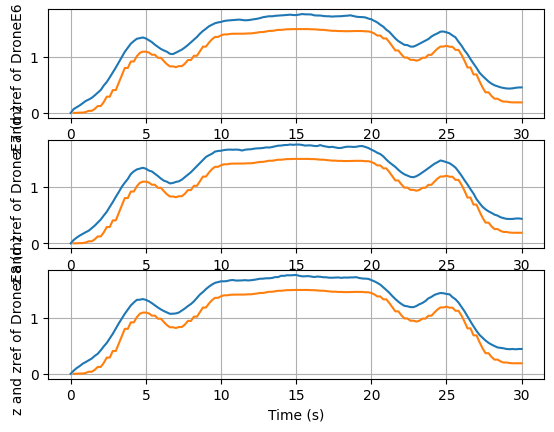

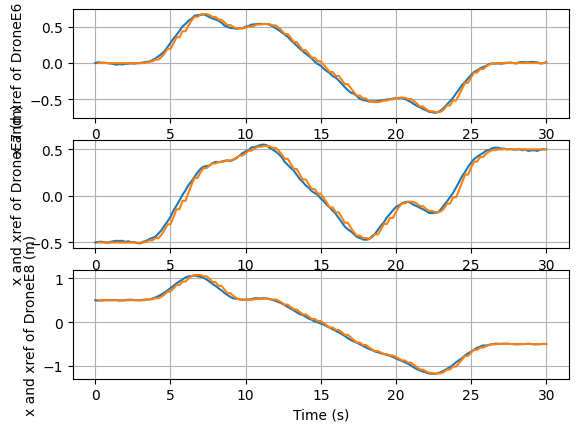

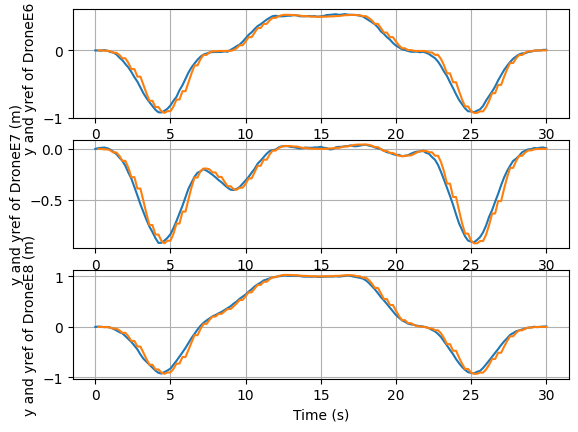

In [7]:
# plot result

import matplotlib.pyplot as plt
# import matplotlib

# # Enable LaTeX formatting
# matplotlib.rc_params['text.usetex'] = True
# plt.rcParams.update({
#     "text.usetex":True,
#     "font.family":"sans-serif"
# })
# Plot position in 3D plot:
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')


for i in range(len(drone_bodies)):
    ax1.plot(simulator['x_sim'][0,:,i],simulator['x_sim'][1,:,i],simulator['x_sim'][2,:,i], '--')
    ax1.scatter(ref[uris[i]][:,0],ref[uris[i]][:,1],ref[uris[i]][:,2])


ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_zlabel('z (m)')

ts = np.linspace(start=0,stop=Tsim,num=simulator['Nsim']+1)
fig12 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig12.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][2,:,i])
    ax1.plot(ts[1:],ref[uris[i]][:,2])
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"z and zref of {drone_bodies[i]} (m)")

fig13 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig13.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][0,:,i])
    ax1.plot(ts[1:],ref[uris[i]][:,0])
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"x and xref of {drone_bodies[i]} (m)")

fig14 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig14.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][1,:,i])
    ax1.plot(ts[1:],ref[uris[i]][:,1])
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"y and yref of {drone_bodies[i]} (m)")

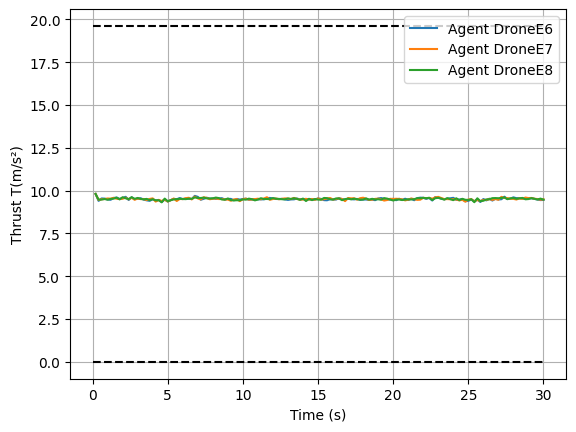

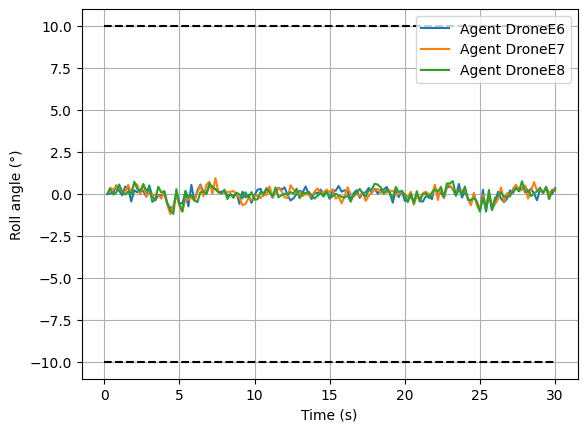

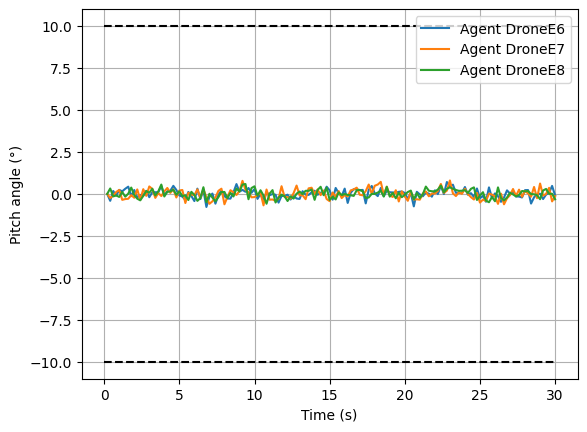

In [9]:
ur = np.zeros((3,simulator['Nsim'],simulator['na']))
for k in range(simulator['Nsim']):
    for i in range(simulator['na']):
        # compute real control u
        ur[:,k,i]= ctrl.get_real_input(v_controls=simulator['u_sim'][:,k,i],yaw=0)
        
# Create a figure and axis object
fig,ax = plt.subplots()

# plot Thrust
g = 9.81
Tmax = 2 * g
for i in range(simulator['na']):
    ax.plot(ts[1:],ur[0,:,i],label=f'Agent {drone_bodies[i]}')
    ax.grid(visible=True)

ax.plot(ts,np.ones(np.size(ts)) * Tmax,'k--',linewidth=1.5)
ax.plot(ts,np.ones(np.size(ts)) * 0,'k--',linewidth=1.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Thrust T(m/s²)')
ax.legend()


phimax = 10 * np.pi/180
thetamax = 10 * np.pi/180

figr,axr = plt.subplots()

for i in range(simulator['na']):
    axr.plot(ts[1:],ur[1,:,i]*180/np.pi,label=f'Agent {drone_bodies[i]}')
    axr.grid(visible=True)

axr.plot(ts,np.ones(np.size(ts)) * phimax*180/np.pi,'k--',linewidth=1.5)
axr.plot(ts,np.ones(np.size(ts)) * -phimax*180/np.pi,'k--',linewidth=1.5)
axr.set_xlabel('Time (s)')
axr.set_ylabel('Roll angle (°)')
axr.legend()

figp,axp = plt.subplots()

for i in range(simulator['na']):
    axp.plot(ts[1:],ur[2,:,i]*180/np.pi,label=f'Agent {drone_bodies[i]}')
    axp.grid(visible=True)

axp.plot(ts,np.ones(np.size(ts)) * thetamax *180/np.pi,'k--',linewidth=1.5)
axp.plot(ts,np.ones(np.size(ts)) * -thetamax *180/np.pi,'k--',linewidth=1.5)
axp.set_xlabel('Time (s)')
axp.set_ylabel('Pitch angle (°)')
axp.legend()